## Problem

**Task [[kaggle](https://www.kaggle.com/c/reface-fake-detection)]:** recognize fake videos. You need to train the binary classifier to distinguish real videos from fake ones (the provided fake data is the result of the technologies developed in Reface).

****

### What I should get?

In order to complete this stage, you should meet one of 2 conditions below:
+ either make a solution with a minimum target metric value of 0.92475
+ or be in the top 30 of all competitors.

****

### Evaluation

The evaluation metric for this competition is F1-Score, average='micro'. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn).

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

More information you can find at sklearn docs:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

****

### Submission

For each filename in the test set, you must predict either this file is fake video (label 1) or this file is real video (label 0). The file should contain a header and have the following format:

```
filename,label
004582.mp4,1
003603.mp4,0
```

## Install external modules and load our data

In [ ]:
!pip install -qq av

     |████████████████████████████████| 37.2 MB 1.1 MB/s 


In [ ]:
!pip install facenet-pytorch > /dev/null 2>&1
!apt install zip > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf reface-fake-detection tmp

In [ ]:
!unzip -qq /content/drive/MyDrive/dl-creator-school/reface-fake-detection/reface-fake-detection.zip -d reface-fake-detection

In [ ]:
# !tar -zcvf train.tar.gz /content/drive/MyDrive/dl-creator-school/reface-fake-detection/train

In [ ]:
# !cp -r /content/drive/MyDrive/dl-creator-school/reface-fake-detection/train train

In [ ]:
# !zip -r train.zip train

In [ ]:
# !ls /content/drive/MyDrive/dl-creator-school/reface-fake-detection/train

## Modules importing

In [ ]:
import os
import glob
import json
import cv2

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision

from torch import nn, optim
from torch.utils.data import sampler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
from torchvision import transforms, datasets
from torchsummary import summary

from facenet_pytorch import MTCNN

from sklearn.model_selection import train_test_split

from PIL import Image
from tqdm.notebook import tqdm

from typing import List, Dict, Tuple, Union, Optional
from pathlib import Path

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150

## Settings

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
PATH2PROJECT = Path('')
PATH2DRIVE = Path('/content/drive/MyDrive/dl-creator-school/')

PATH2DATA = PATH2PROJECT / 'reface-fake-detection'
PATH2TRAIN = PATH2DATA / 'train'
PATH2TEST = PATH2DATA / 'test'
# PATH2SUBMISSIONS = PATH2DRIVE / 'submissions'
# PATH2CHECKOUTS = PATH2DRIVE / 'checkouts'

PATH2RESULT = PATH2PROJECT / 'reface-fake-detection-result'
PATH2RESULT_TRAIN = PATH2RESULT / 'train'
PATH2RESULT_TEST = PATH2RESULT / 'test'

In [ ]:
# try: PATH2SUBMISSIONS.mkdir()
# except: pass
# try: PATH2CHECKOUTS.mkdir()
# except: pass
try: PATH2RESULT.mkdir()
except: pass
try: PATH2RESULT_TRAIN.mkdir()
except: pass
try: PATH2RESULT_TEST.mkdir()
except: pass

In [ ]:
SEED = 42
# VAL_SIZE = 0.3

In [ ]:
SCALE = 0.25
N_FRAMES = 15

## Training metadata

In [ ]:
meta_df = pd.read_csv(PATH2DATA / 'train.csv')
meta_df.shape

(41161, 2)

In [ ]:
meta_df.sample(n=5, random_state=SEED)

,filename,label
12469,dnmwxnsqazhbrzbwhcyeeitekhssbmmx.mp4,1
16106,mjfvkdjclgbgbeikregomzvancvoyien.mp4,0
144,pbjvfdegxlmysnyelopgwdqglzjgheep.mp4,1
6442,rwecopvulhnwevpzsfupgdzwdjfenmcr.mp4,1
39989,bvchibtmrvczfpytenatbaqvbulkjbve.mp4,0


In [ ]:
meta_df.label.value_counts(normalize=True)

0    0.658706
1    0.341294
Name: label, dtype: float64

## Stratified split data on test and validation

In [ ]:
# f_train, f_val, y_train, y_val = train_test_split(
#     meta_df[['filename']],
#     meta_df['label'],
#     test_size=VAL_SIZE,
#     random_state=SEED, 
#     stratify=meta_df['label']
# )

In [ ]:
# np.mean(y_train), np.mean(y_val)

In [ ]:
# assert not set(f_train.filename.tolist()) & set(f_val.filename.tolist()), 'intersection is not empty'

## Show few frames

In [ ]:
t = os.listdir(PATH2TRAIN / 'train')
temp_filename = t[np.random.randint(0, high=len(t))]
data = torchvision.io.read_video(str(PATH2TRAIN / 'train' / temp_filename), pts_unit='sec')
del t

In [ ]:
vid = data[0]
aud = data[1]

print("Video Shape: {}\nAudio Shape: {}\n".format(vid.shape, aud.shape))

Video Shape: torch.Size([28, 160, 160, 3])
Audio Shape: torch.Size([1, 17408])



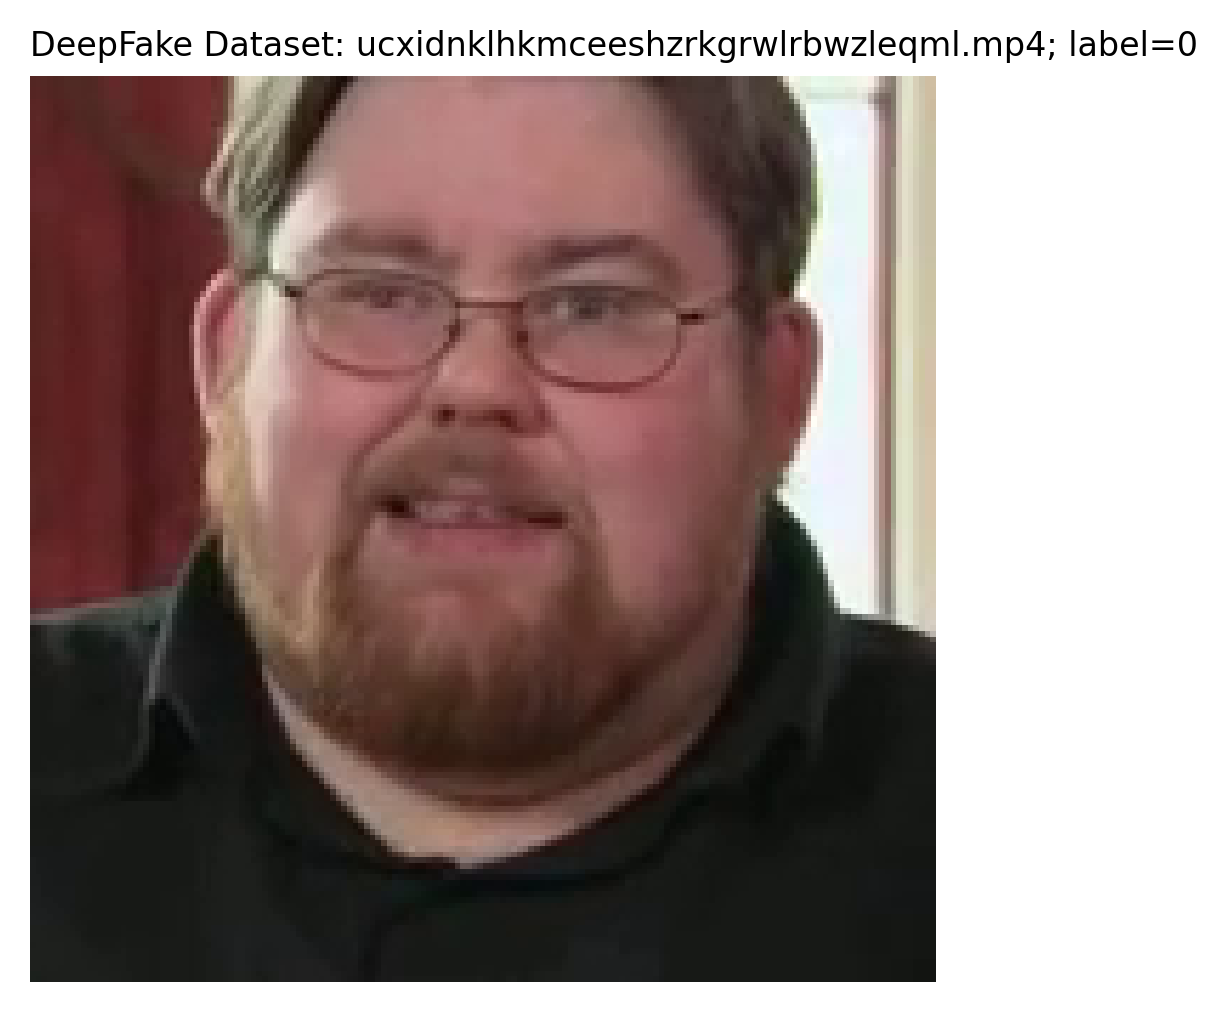

In [ ]:
plt.imshow(vid[10])
plt.title(f"DeepFake Dataset: {temp_filename}; label={meta_df[meta_df.filename == temp_filename].label.values[0]}", loc='left', fontsize=8, pad=5);
plt.axis("off");

## Define Face Extractor

In [ ]:
class FaceExtractor:
    def __init__(self, detector, n_frames=None, resize=None):
        """
        Parameters:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """

        self.detector = detector
        self.n_frames = n_frames
        self.resize = resize
    
    def __call__(self, filename, save_dir):
        """Load frames from an MP4 video, detect faces and save the results.

        Parameters:
            filename {str} -- Path to video.
            save_dir {str} -- The directory where results are saved.
        """

        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])

                save_path = os.path.join(save_dir, f'{j}.png')

                self.detector([frame], save_path=save_path)

        v_cap.release()

## Face extraction process

In [ ]:
# Load face detector
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

In [ ]:
# Define face extractor
face_extractor = FaceExtractor(detector=face_detector, n_frames=N_FRAMES, resize=SCALE)

In [ ]:
# Get the paths of all train videos
all_train_videos = glob.glob(os.path.join(PATH2TRAIN / 'train', '*.mp4'))
all_res_train_videos = os.listdir(PATH2RESULT_TRAIN)

all_train_videos = [path for path in all_train_videos if (path.split('/')[-1].split('.')[0] not in all_res_train_videos)]

In [ ]:
len(glob.glob(os.path.join(PATH2TRAIN / 'train', '*.mp4'))), len(all_train_videos)

(41161, 41161)

In [ ]:
# Get the paths of all test videos
all_test_videos = glob.glob(os.path.join(PATH2TEST / 'test', '*.mp4'))
all_res_test_videos = os.listdir(PATH2RESULT_TEST)

all_test_videos = [path for path in all_test_videos if (path.split('/')[-1].split('.')[0] not in all_res_test_videos)]

In [ ]:
from joblib import Parallel, delayed

In [ ]:
def compute_face_extractor(path, save_path):
    file_name = path.split('/')[-1]

    save_dir = os.path.join(save_path, file_name.split(".")[0])

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Detect all faces appear in the video and save them.
    face_extractor(path, save_dir)

In [ ]:
with torch.no_grad():
    Parallel(n_jobs=-1, verbose=5)(delayed(compute_face_extractor)(path, PATH2RESULT_TRAIN) for path in tqdm(all_train_videos))

  0%|          | 0/41161 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | ela

In [ ]:
# Parallel(n_jobs=-1, verbose=5)(delayed(compute_face_extractor)(path, PATH2RESULT_TEST) for path in tqdm(all_test_videos))

In [ ]:
meta_df.to_csv(PATH2RESULT / 'train.csv', index=False)

In [ ]:
!tar -zcvf reface-fake-detection-result.tar.gz reface-fake-detection-result

Выходные данные были обрезаны до нескольких последних строк (5000).
reface-fake-detection-result/train/xjnlqlgrasfwahsycgjenwaaffjvveax/15.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/22.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/45.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/59.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/41.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/18.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/54.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/4.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/50.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/36.png
reface-fake-detection-result/train/rqdilfzcsvnjwanufqlcqdgwlbalgdex/0.png
reface-fake-detection-result/train/rqdil

In [ ]:
!cp reface-fake-detection-result.tar.gz /content/drive/MyDrive/dl-creator-school/reface-fake-detection-result.tar.gz

In [ ]:
!ls /content/drive/MyDrive/dl-creator-school

reface-fake-detection-result.tar.gz


In [ ]:
!ls /content/drive/MyDrive/

'Colab Notebooks'   dl-creator-school


In [ ]:
from google.colab import files
files.download('reface-fake-detection-result.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !rm -rf $PATH2TRAIN/'train'

In [ ]:
# !rm -rf $PATH2TEST/'test'